In [8]:
import numpy as np
import sympy as sp

%matplotlib nbagg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.special import erf

import pickle

In [60]:
kappa=0.1
Bottom = 0
Top = 1
eps=.0005
T=1;

nsteps = int(2e3)
t = np.linspace(T, 0, nsteps+1)
tau = t[0]-t

def V(x,t):
    return 0
    #return -x + np.sin(t)

numberOfSpacePoints = 100
xx         = np.linspace(Bottom, Top, numberOfSpacePoints)
npoints = len(xx)
nparticles = 1000


ll         = np.zeros(npoints)
xfull      = np.zeros(shape = (nsteps+1, npoints, nparticles, 1), dtype = np.float32)
localtimeL = np.zeros(shape = (nsteps+1, npoints, nparticles), dtype = np.float32)
localtimeR = np.zeros(shape = (nsteps+1, npoints, nparticles), dtype = np.float32)
xfull[...,0] = xx[:, None]

In [61]:
for tindex in range(nsteps):
    #print('step {0}'.format(tindex))
    # get velocity
    u = V(xfull[tindex],tindex)
    # Euler Maruyama
    dt = t[tindex]-t[tindex+1]
    dW = np.random.randn(*xfull.shape[1:])*np.sqrt(dt)
    dX =  - u*dt + np.sqrt(2*kappa)*dW
    xfull[tindex+1] = xfull[tindex] + dX
    localtimeL[tindex+1] = localtimeL[tindex] 
    localtimeR[tindex+1] = localtimeR[tindex] 
    for k in range(npoints):
        for j in range(nparticles):
            if xfull[tindex][k,j,:] < Bottom + eps:
                VV = -2*dt*np.log(np.random.rand());
                Y = (-dX[k,j,:]+np.sqrt(2*kappa*VV+dX[k,j,:]**2))/2;
                dL = max(0,Y-xfull[tindex][k,j,0] + Bottom);
                xfull[tindex+1][k,j,0] = xfull[tindex][k,j,0] + dL 
                localtimeL[tindex+1][k,j] = localtimeL[tindex+1][k,j] + dL/kappa
            if xfull[tindex][k,j,:] > Top - eps:
                VV = -2*dt*np.log(np.random.rand());
                Y = (dX[k,j,:]+np.sqrt(2*kappa*VV+dX[k,j,:]**2))/2;
                dL = max(0,Y+xfull[tindex][k,j,0] - Top);
                xfull[tindex+1][k,j,0] = xfull[tindex][k,j,0] - dL 
                localtimeR[tindex+1][k,j] = localtimeR[tindex+1][k,j] + dL/kappa
            xfull[tindex+1][k,j,0] = max(min(xfull[tindex+1][k,j,0],Top),Bottom); 

In [63]:
#pickle.dump(xfull, open( "xfull_Brown.p", "wb" ) )
#pickle.dump(t, open( "t_Brown.p", "wb" ) )

xfull = pickle.load( open( "xfull_Brown.p", "rb" ) )
timeline1 = pickle.load( open( "t_Brown.p", "rb" ) )

<IPython.core.display.Javascript object>


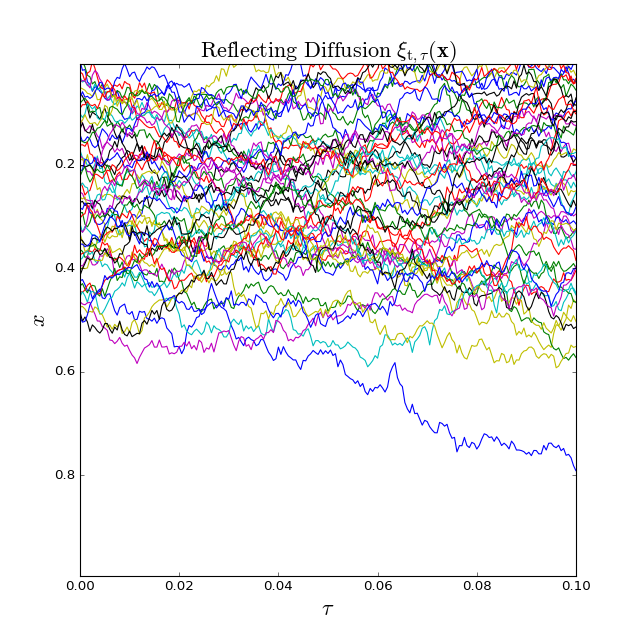

<IPython.core.display.Javascript object>


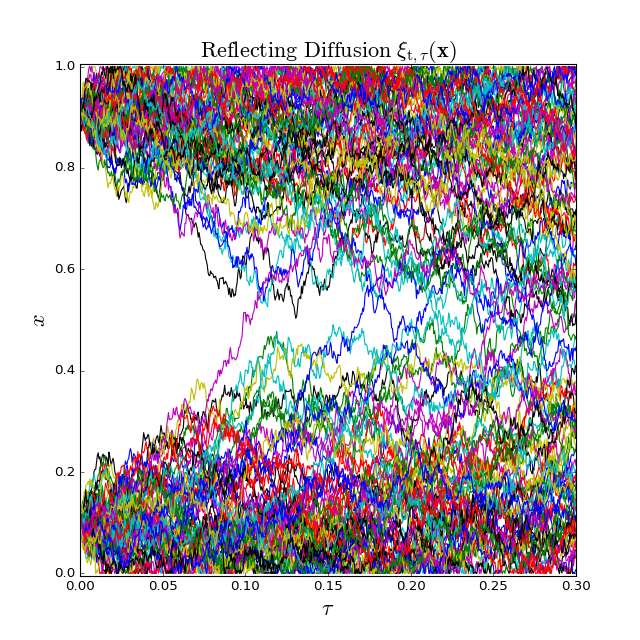

In [64]:
molecular_traj = xfull

particleindx = -1
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
for i in range(npoints/2):
    ax.plot(tau,molecular_traj[:, i, particleindx, 0])
ax.set_ylim([Top-10*eps,Bottom+10*eps])
ax.set_xlim([0,0.1])
ax.set_title('$\\rm Reflecting\ Diffus ion\ {\\xi}_{t,\\tau}(\\mathbf{x})$', fontsize=20)
ax.set_xlabel('$\\tau $', fontsize=20)
ax.set_ylabel('$x$', fontsize=20)

space_indx1 = 10
space_indx2 = -10
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
for i in range(nparticles/15):
    ax.plot(tau,molecular_traj[:, space_indx1, i, 0])
    ax.plot(tau,molecular_traj[:, space_indx2, i, 0])
ax.set_ylim([Bottom-10*eps,Top+10*eps,])
ax.set_xlim([0,0.3])
ax.set_title('$\\rm Reflecting\ Diffusion\ {\\xi}_{t,\\tau}(\\mathbf{x})$', fontsize=20)
ax.set_xlabel('$\\tau $', fontsize=20)
ax.set_ylabel('$x$', fontsize=20)

0.10101010101


<IPython.core.display.Javascript object>


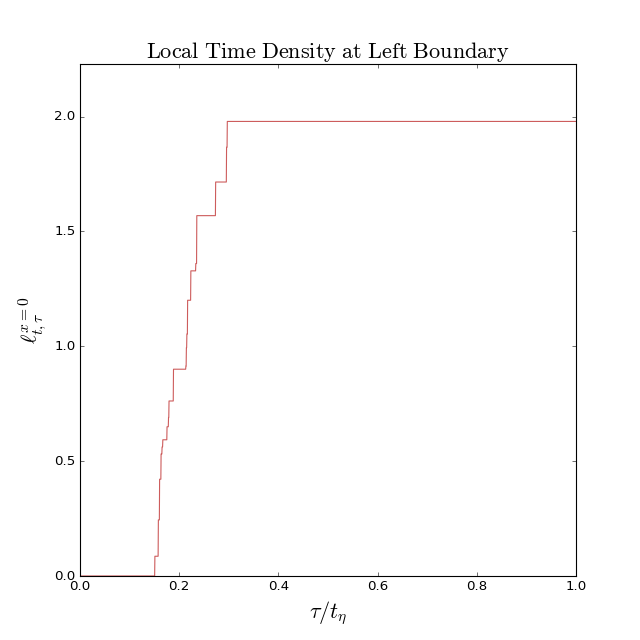

In [65]:
molecular_traj = xfull
space_indx = 10
print xx[space_indx]
particleindx = 1
LTL = localtimeL[:, space_indx, particleindx]
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.plot(tau,LTL,color = 'Indianred')
ax.set_title('$\\rm Local\ Time\ Density\ at\ Left\ Boundary$', fontsize=20)
ax.set_ylim([0,np.max(LTL)+0.25,])
ax.set_xlim([0,1])
ax.set_xlabel('$\\tau / t_\\eta$', fontsize=20)
ax.set_ylabel('$\\ell^{x=0}_{t,\\tau}$', fontsize=20)

0.909090909091


<IPython.core.display.Javascript object>


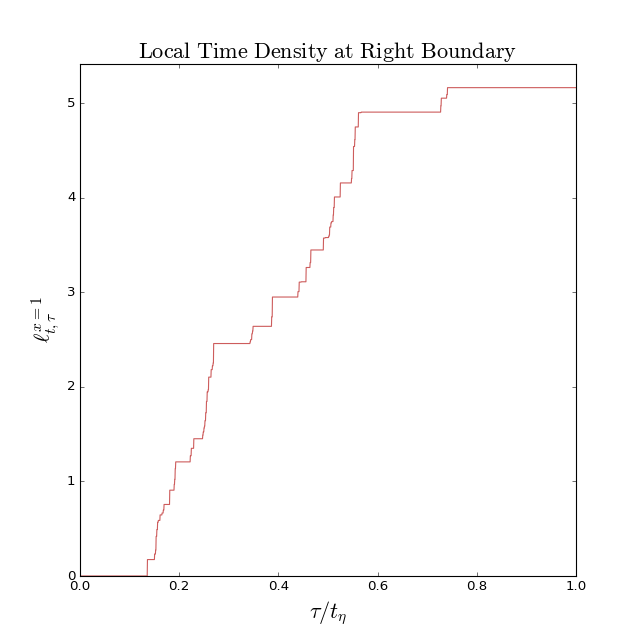

In [67]:
molecular_traj = xfull
space_indx = -10
print xx[space_indx]
particleindx = 9
LTR = localtimeR[:, space_indx, particleindx]
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.plot(tau,LTR,color = 'Indianred')
ax.set_title('$\\rm Local\ Time\ Density\ at\ Right\ Boundary$', fontsize=20)
ax.set_ylim([0,np.max(LTR)+0.25,])
ax.set_xlim([0,1])
ax.set_xlabel('$\\tau / t_\\eta$', fontsize=20)
ax.set_ylabel('$\\ell^{x=1}_{t,\\tau}$', fontsize=20)

In [68]:
time_index = len(t)-1
ELL   = np.zeros(npoints)
ELR   = np.zeros(npoints)
VarLL = np.zeros(npoints)
VarLR = np.zeros(npoints)
CovL  = np.zeros(npoints)
for i in range(npoints):
    #print('step {0}'.format(npoints))
    localtimeL_Ave = np.average(localtimeL, axis = 2)
    localtimeR_Ave = np.average(localtimeR, axis = 2)
    localtimeL_Var = np.average(localtimeL**2, axis = 2)         - localtimeL_Ave**2
    localtimeR_Var = np.average(localtimeR**2, axis = 2)         - localtimeR_Ave**2
    localtime_Cov  = np.average(localtimeR*localtimeL, axis = 2) - localtimeR_Ave*localtimeL_Ave
    ELL[i]   = localtimeL_Ave[time_index, i]
    ELR[i]   = localtimeR_Ave[time_index, i]
    VarLL[i] = localtimeL_Var[time_index, i]
    VarLR[i] = localtimeR_Var[time_index, i]
    CovL[i]  = localtime_Cov[time_index,  i]

<IPython.core.display.Javascript object>


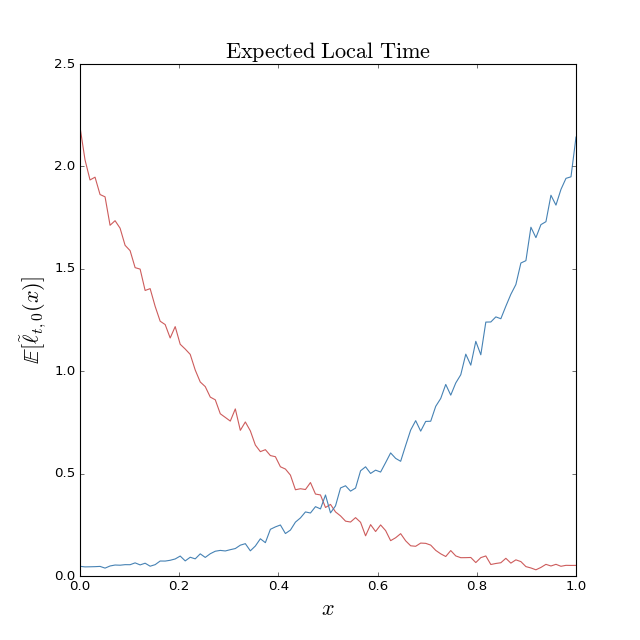

<IPython.core.display.Javascript object>


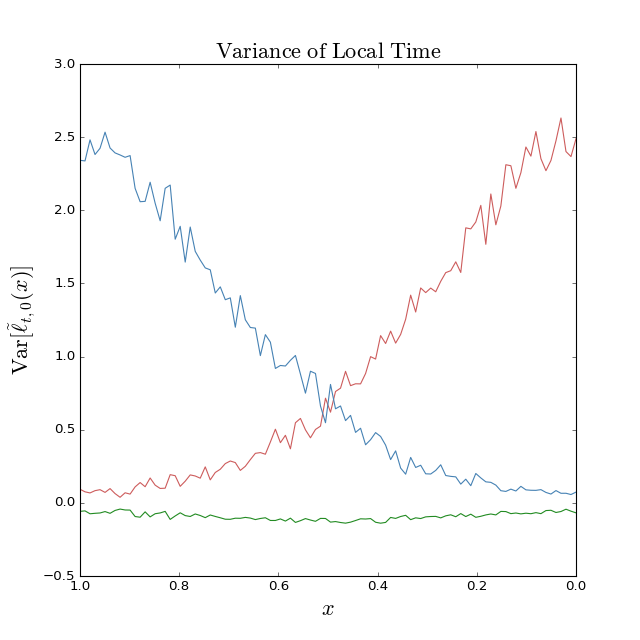

In [69]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.plot(xx, ELL, color = 'Indianred')
ax.plot(xx, ELR, color = 'Steelblue')
ax.set_xlim([Bottom,Top])
ax.set_title('$\\rm Expected\ Local\ Time$', fontsize=20)
ax.set_xlabel('$x$', fontsize=20)
ax.set_ylabel('$\\mathbb{E}[\\tilde{\\ell}_{t,0}(x)]$', fontsize=20)


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.plot(xx, VarLL, color = 'Indianred')
ax.plot(xx, VarLR, color = 'Steelblue')
ax.plot(xx, CovL, color = 'Forestgreen')
ax.set_xlim([Top,Bottom])
ax.set_title('$\\rm Variance\ of\ Local\ Time$', fontsize=20)
ax.set_xlabel('$x$', fontsize=20)
ax.set_ylabel('${\\rm Var}[\\tilde{\\ell}_{t,0}(x)]$', fontsize=20)

<IPython.core.display.Javascript object>


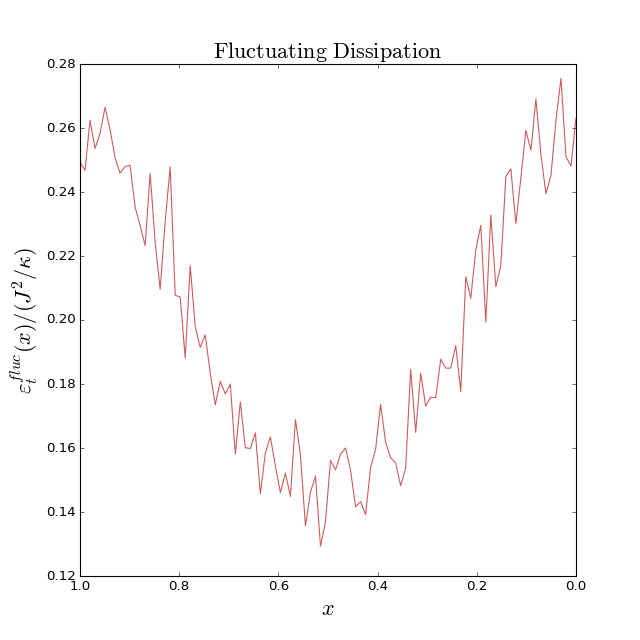

In [70]:
J=1
FluctuatingDissipation = VarLL + VarLR - CovL
FluctuatingDissipation = FluctuatingDissipation/(J**2/kappa)


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.plot(xx, FluctuatingDissipation, color = 'Indianred')
ax.set_xlim([Top,Bottom])
ax.set_title('$\\rm Fluctuating\ Dissipation$', fontsize=20)
ax.set_xlabel('$x$', fontsize=20)
ax.set_ylabel('$\\varepsilon_t^{fluc}(x)/(J^2/\kappa)$', fontsize=20)

Use Takac's Eq.(3) as a test on the numerics. For a Brownian motion started at $x_0>0$ at time $t$ and reflected at $x=0$, the PDF $p_{x_0,\tau}(\ell)$ of the local time density at $x=0$ is 

$ p_{x_0,\tau}(\ell)=   \Big(\sqrt{\frac{\kappa}{\pi \tau}} e^{-(x_0+2\kappa \ell)^2/4\kappa \tau}\Big) \Theta(\ell) + \Big(2\Phi_{\kappa,\tau}(x_0)-1\Big) \delta(\ell)$

where $\tau=t-s$, $\Theta(\ell)$ is the Heaviside set-function and $\Phi_{\kappa,t}(x)=\frac{1}{\sqrt{4\pi\kappa t}} \int_{-\infty}^{x} dy\  e^{-y^2/4\kappa t}$ (i.e., the CDF of the normal random variable $N(0,2\kappa t)$).  The CDF is:

$ P_{x_0,\tau}(\ell\leq L)= 2\Phi_{\kappa,\tau}(x_0+ 2\kappa L)-1 =  {\rm erf}\big(\frac{ x_0+ 2\kappa L}{\sqrt{4\kappa \tau}}\big)$

where the error function is defined as ${\rm erf}(x) = \frac{1}{\sqrt{2\pi}}\int_{-x}^x dy\  e^{-y^2}$.

In [192]:
def CDFofNormal(x,t):
    return (1/2.)*(1+erf(x/np.sqrt(4*kappa*t)))

def localTimePDF(ell,x0,t):
    return np.sqrt(kappa/np.pi*t)*np.exp(1)**(-(x0 + 2*kappa*ell)**2/(4*kappa*t))

def localTimeCDF(L,x0,t):
    return  2*CDFofNormal(x0+2*kappa*L,t)-1 

<IPython.core.display.Javascript object>


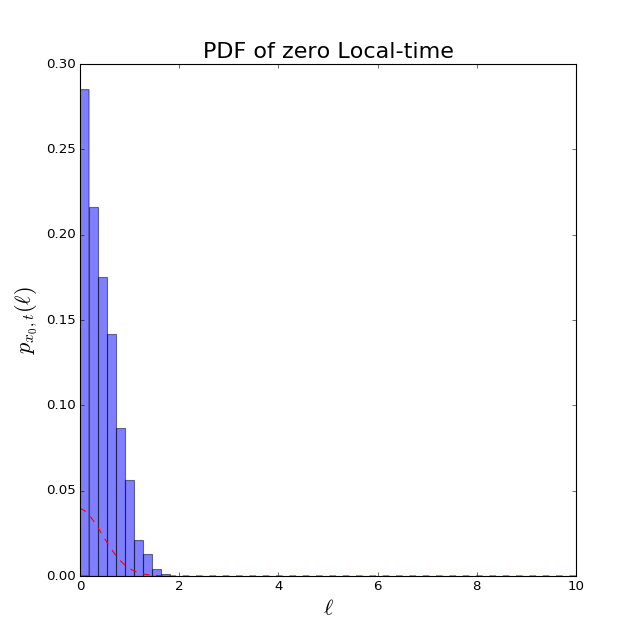

/Users/tdrivas/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/tdrivas/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


<IPython.core.display.Javascript object>


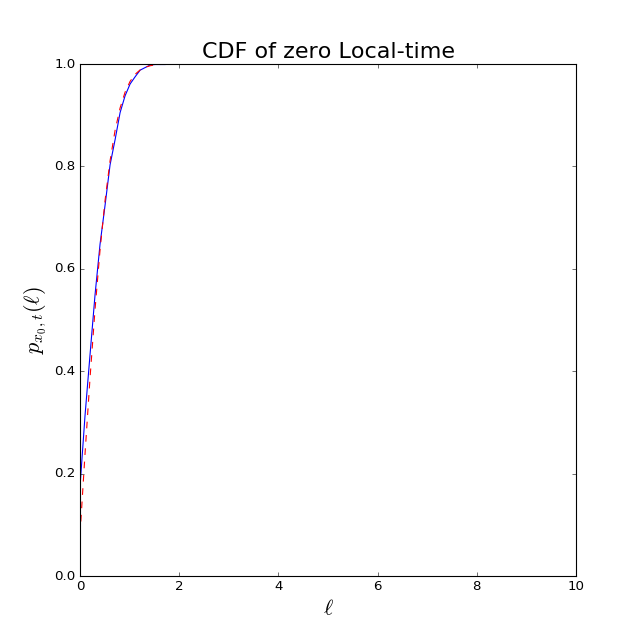

/Users/tdrivas/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:22: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/tdrivas/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:23: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/tdrivas/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:25: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [198]:
time_index = 100
L = localtimeL[time_index,:,:]
R = localtimeR[time_index,:,:]

bins = np.linspace(0, 10, 100)
x0 = [xx[-1]]
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
for x0i in x0:
    data = localtimeL[time_index,x0i,:]
    #ax.hist(localtimeL[time_index,x0i,:], bins = bins, normed = 0, alpha=0.5)
    weights = np.ones_like(data)/len(data)
    ax.hist(data, weights=weights, alpha=0.5)
    ax.plot(bins, localTimePDF(bins, xx[x0i], tau[time_index]), 'r--')
ax.set_title('PDF of zero Local-time', fontsize=20)
ax.set_xlabel('$\ell$', fontsize=20)
ax.set_ylabel('$p_{x_0,t}(\\ell)$', fontsize=20)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
for x0i in x0:
    values, base = np.histogram(localtimeL[time_index, x0i,:], bins = bins, normed = 0)
    cumulative = np.cumsum(values)/float(localtimeL[time_index,x0i,:].shape[0])
    ax.plot(base[:-1], cumulative, c='blue')
    ax.plot(bins, localTimeCDF(bins, xx[x0i], tau[time_index]), 'r--')
ax.set_title('CDF of zero Local-time', fontsize=20)
ax.set_xlabel('$\ell$', fontsize=20)
ax.set_ylabel('$p_{x_0,t}(\\ell)$', fontsize=20)